# Dirichlet process Gaussian mixture model (DPGMM)-based automatic spike sorting
`DPGMMSpikeSort.ipynb`

Here we will use a Dirichlet process Gaussian mixture model (DPGMM) to automatically sort spikes from a single tetrode.

**Assumptions:** it is assumed that large amplitude noise artifacts have already been removed from the spike data, so that the remaining data are overwhelmingly likely to be spikes (but not necessarily sortable spikes). We also assume that other preprocessing steps have been taken, e.g., spike alignment. In other words, this notebook is *only* about automatic sorting of unsorted spikes using the DPGMM. Many other methods exist, and this is not meant to suggest that his approach is the recommended approach, but rather that this is a simple and intuitive approach, that we may want to use in an early exploratory phase of our data analysis.

Notebook was created by _Etienne Ackermann_.

### Data description

There are two pieces of data that we will load, namely `waveforms` and `spiketimes`.

**`waveforms`:** This is a matrix of action potential waveforms sampled simultaneously on all four channels of the tetrode. The size is $M×4×40$, where $M =$ 12940 is the number of action potentials detected, and the recorded portion of the action potential waveform ("snippet") is in a 40 sample window around the threshold crossing, on all four channels of the tetrode. The sampling rate is 30 kHz, and the data are simultaneous voltage signals (in μV) from each channel.

**`spiketimes`:** peak times (in sample numbers, also with 30 kHz sampling rate) corresponding to each of the $M=$12940 `waveforms`.

In [1]:
# import itertools
import numpy as np
import matplotlib.pyplot as plt

import nelpy as nel
import nelpy.plotting as npl
import nelpy.examples as nex

from sklearn import mixture

%matplotlib inline
# plt.style.use('dark_background')

npl.setup()

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


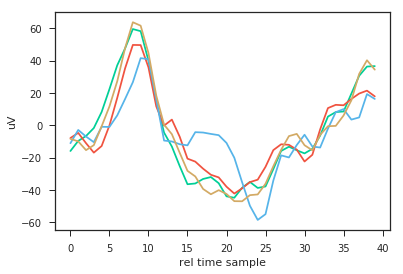

In [2]:
# laod data
waveforms, spiketimes = nex.load_example_dataset('spike-sorting')

n_spikes, n_channels, snippet_length = waveforms.shape

# plot waveforms corresponding to first spike
plt.plot(waveforms[0].T)
plt.xlabel('rel time sample')
plt.ylabel('uV');

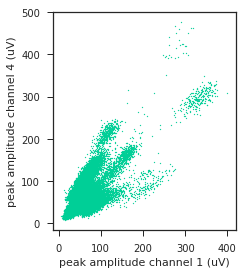

In [3]:
# compute features:
peaks = waveforms.max(axis=2)

plt.scatter(peaks[:,0], peaks[:,3], 1)
plt.xlabel('peak amplitude channel 1 (uV)')
plt.ylabel('peak amplitude channel 4 (uV)')
ax = plt.gca()
ax.set_aspect('equal');

In [4]:
def spike_sort(spiketimes, waveforms, min_spikes_per_cluster=25, n_clusters=10, max_n_clusters = 50):
    
    # compute features:
    peaks = waveforms.max(axis=2)
    X = peaks
    # X is MxN; M samples of an N-dimensional signal
    _, N = X.shape # N number of features
    
    dpgmm = mixture.BayesianGaussianMixture(
        n_components=max_n_clusters, covariance_type='full', weight_concentration_prior=1e-3,
        weight_concentration_prior_type='dirichlet_process', init_params="kmeans",
        max_iter=300, random_state=0).fit(X) # init can be "kmeans" or "random"
    
    Y = dpgmm.predict(X)
    n_spikes_per_cluster = np.histogram(Y, bins=len(dpgmm.means_)-1)[0]
    
    # identify 'biggest' amplitude units (which we here naively assume to be the best)
    best_k_units = np.array([clust for clust in np.argsort(np.linalg.norm(dpgmm.means_, ord=2, axis=1)) if clust in np.argwhere(n_spikes_per_cluster > min_spikes_per_cluster).squeeze()])[-n_clusters:].squeeze()

    keep_spk_idx = np.argwhere([y in best_k_units for y in Y]).squeeze()
    
    unit_ids = np.zeros(len(spiketimes))
    spikes = [[]]
    for uu, unit_id in enumerate(best_k_units):
        unit_ids[Y==unit_id]  = uu+1
        spikes.append(spiketimes[Y==unit_id])
    spikes[0] = spiketimes[unit_ids==0]
    
    spiketrain = nel.SpikeTrainArray(timestamps=spikes)
               
    return spiketrain, unit_ids, peaks
    

In [5]:
fs = 30000
st, unit_ids, peaks = spike_sort(spiketimes/fs, waveforms)

C:\Users\etien\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
d:\dropbox\code\nelpy\nelpy\core\_spiketrain.py:526: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


In [6]:
print(st) # unit_id 0 corresponds to unsorted units

<SpikeTrainArray at 0x1a52f64f9e8: 11 units> at 30000 Hz


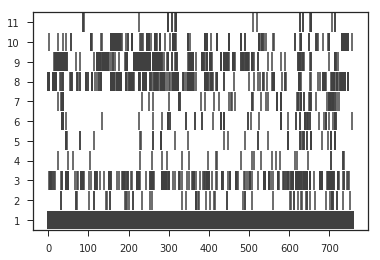

In [7]:
npl.rasterplot(st)

In [8]:
def plot_results(X, Y):
    splot = plt.subplot(3, 2, 1)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
    splot = plt.subplot(3, 2, 2)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
    splot = plt.subplot(3, 2, 3)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
    splot = plt.subplot(3, 2, 4)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
    splot = plt.subplot(3, 2, 5)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
    splot = plt.subplot(3, 2, 6)
    plt.scatter(X[Y == 0, 0], X[Y == 0, 1], 0.2, color='0.2')
        
        
    for i in range(1, int(unit_ids.max()+1)):
        if not np.any(Y == i):
            continue
        splot = plt.subplot(3, 2, 1)
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 2)
        ax = plt.gca()
        ax.set_aspect('equal')
        
        splot = plt.subplot(3, 2, 2)
        plt.scatter(X[Y == i, 0], X[Y == i, 2], 2)
        ax = plt.gca()
        ax.set_aspect('equal')
        
        splot = plt.subplot(3, 2, 3)
        plt.scatter(X[Y == i, 0], X[Y == i, 3], 2)
        ax = plt.gca()
        ax.set_aspect('equal')
        
        splot = plt.subplot(3, 2, 4)
        plt.scatter(X[Y == i, 1], X[Y == i, 2], 2)
        ax = plt.gca()
        ax.set_aspect('equal')
        
        splot = plt.subplot(3, 2, 5)
        plt.scatter(X[Y == i, 1], X[Y == i, 3], 2)
        ax = plt.gca()
        ax.set_aspect('equal')
        
        splot = plt.subplot(3, 2, 6)
        plt.scatter(X[Y == i, 2], X[Y == i, 3], 2)
        ax = plt.gca()
        ax.set_aspect('equal')

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


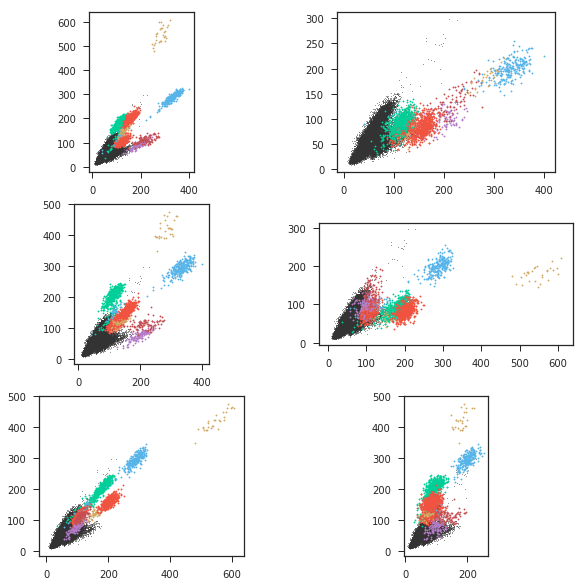

In [9]:
with npl.FigureManager(show=True, figsize=(10,10)):
    plot_results(peaks, unit_ids)

In [ ]:
def build_unit_color_dict(unit_ids, cmap=None):

    import itertools
    if cmap is None:
        cmap = plt.cm.tab10 # tab20

    colors = itertools.cycle(cmap.colors)
    
    color_dict = {}
    for unit_id in unit_ids:
        color_dict[unit_id] = next(colors)
        
    return color_dict